In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
#imports 
import numpy as np
import h5py
import scipy.io
from sklearn.metrics import confusion_matrix
import pandas as pd
from DCASE_plots import plot_confusion_matrix

import librosa
import soundfile as sound
import keras
import tensorflow
print("Librosa version = ",librosa.__version__)
print("Pysoundfile version = ",sound.__version__)
print("keras version = ",keras.__version__)
print("tensorflow version = ",tensorflow.__version__)

Librosa version =  0.10.1
Pysoundfile version =  0.12.1
keras version =  2.8.0
tensorflow version =  2.8.0


In [9]:
#Task 1a dev validation set
ThisPath = '../data/TAU2019Dev/TAU-urban-acoustic-scenes-2019-development/'
File = ThisPath + 'evaluation_setup/fold1_evaluate.csv'
sr = 48000
SampleDuration = 10
NumFreqBins = 128
NumFFTPoints = 2048
HopLength = int(NumFFTPoints/2)
NumTimeBins = int(np.ceil(SampleDuration*sr/HopLength))

In [10]:
#load filenames and labels
dev_test_df = pd.read_csv(File,sep='\t', encoding='ASCII')
wavpaths = dev_test_df['filename'].tolist()
ClassNames = np.unique(dev_test_df['scene_label'])
y_val_labels =  dev_test_df['scene_label'].astype('category').cat.codes.values

#swap codes for 2 and 1 to match the DCASE ordering of classes
a1=np.where(y_val_labels==2)
a2=np.where(y_val_labels==3)
y_val_labels.setflags(write=1)
y_val_labels[a1] = 3
y_val_labels[a2] = 2

In [11]:
#load wav files and get log-mel spectrograms, deltas, and delta-deltas
def deltas(X_in):
    X_out = (X_in[:,:,2:,:]-X_in[:,:,:-2,:])/10.0
    X_out = X_out[:,:,1:-1,:]+(X_in[:,:,4:,:]-X_in[:,:,:-4,:])/5.0
    return X_out

LM_val = np.zeros((len(wavpaths),NumFreqBins,NumTimeBins,2),'float32')
for i in range(len(wavpaths)):
    stereo,fs = sound.read(ThisPath + wavpaths[i],stop=SampleDuration*sr)
    for channel in range(2):
        LM_val[i,:,:,channel]= librosa.feature.melspectrogram(y=stereo[:,channel], 
                                       sr=sr,
                                       n_fft=NumFFTPoints,
                                       hop_length=HopLength,
                                       n_mels=NumFreqBins,
                                       fmin=0.0,
                                       fmax=sr/2,
                                       htk=True,
                                       norm=None)

LM_val=np.log(LM_val)
LM_deltas_val = deltas(LM_val)
LM_deltas_deltas_val = deltas(LM_deltas_val)
LM_val = np.concatenate((LM_val[:,:,4:-4,:],LM_deltas_val[:,:,2:-2,:],LM_deltas_deltas_val),axis=-1)

In [13]:
#load and run the model
best_model = keras.models.load_model('pretrained_models/DCASE_Task1a_development.h5')
y_pred_val = np.argmax(best_model.predict(LM_val),axis=1)


overall accuracy:  0.822700119474313
Normalized confusion matrix
per-class accuracy (recall):  [0.73634204 0.88674699 0.80689655 0.81524249 0.90932642 0.7002584
 0.80725624 0.82051282 0.93532338 0.81422018]
per-class precision:  [0.81151832 0.87410926 0.82009346 0.81902552 0.91884817 0.80654762
 0.76724138 0.84210526 0.79661017 0.78713969]
mean per-class recall:  0.82321255223722
mean per-class precision:  0.824323885637634


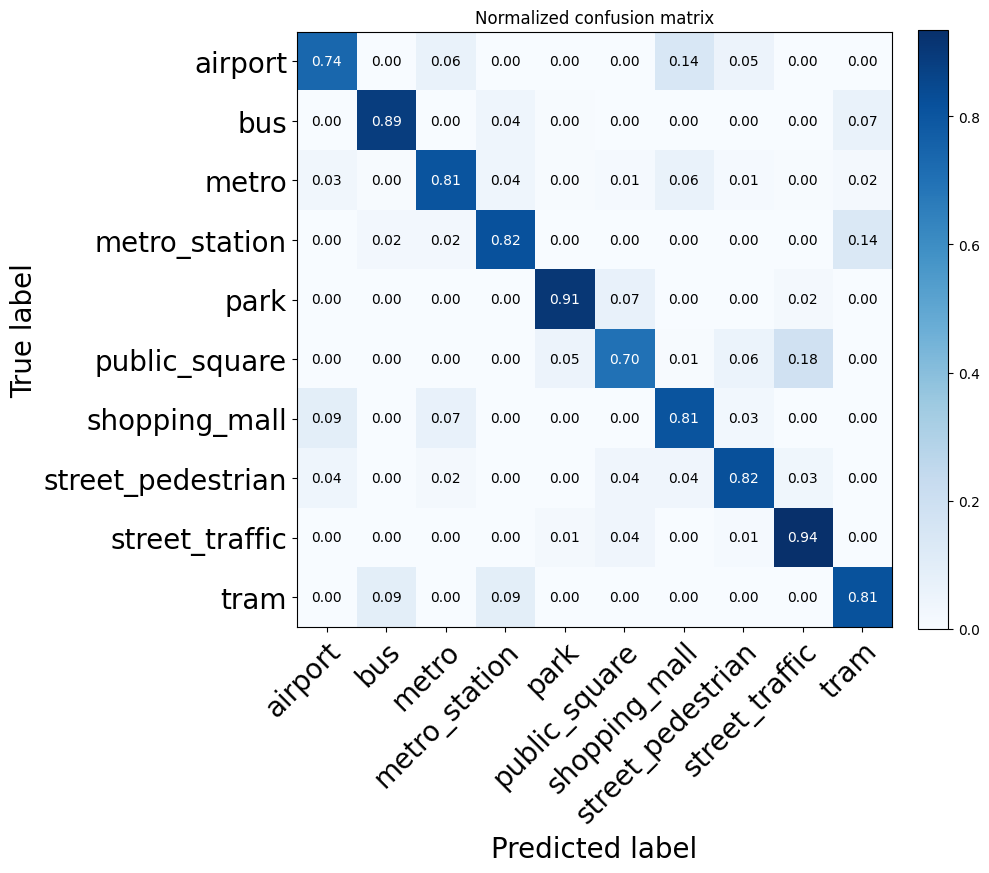

In [14]:
#get metrics
Overall_accuracy = np.sum(y_pred_val==y_val_labels)/LM_val.shape[0]
print("overall accuracy: ", Overall_accuracy)

plot_confusion_matrix(y_val_labels, y_pred_val, ClassNames,normalize=True,title=None)

conf_matrix = confusion_matrix(y_val_labels,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
precision_by_class = np.diagonal(conf_mat_norm_precision)
mean_recall = np.mean(recall_by_class)
mean_precision = np.mean(precision_by_class)

print("per-class accuracy (recall): ",recall_by_class)
print("per-class precision: ",precision_by_class)
print("mean per-class recall: ",mean_recall)
print("mean per-class precision: ",mean_precision)

overall accuracy:  0.822700119474313
Normalized confusion matrix
per-class accuracy (recall):  [0.73634204 0.88674699 0.80689655 0.81524249 0.90932642 0.7002584
 0.80725624 0.82051282 0.93532338 0.81422018]
per-class precision:  [0.80939948 0.87410926 0.82009346 0.81902552 0.91884817 0.8041543
 0.76724138 0.8441247  0.79830149 0.78713969]
mean per-class recall:  0.82321255223722
mean per-class precision:  0.8242437446988766


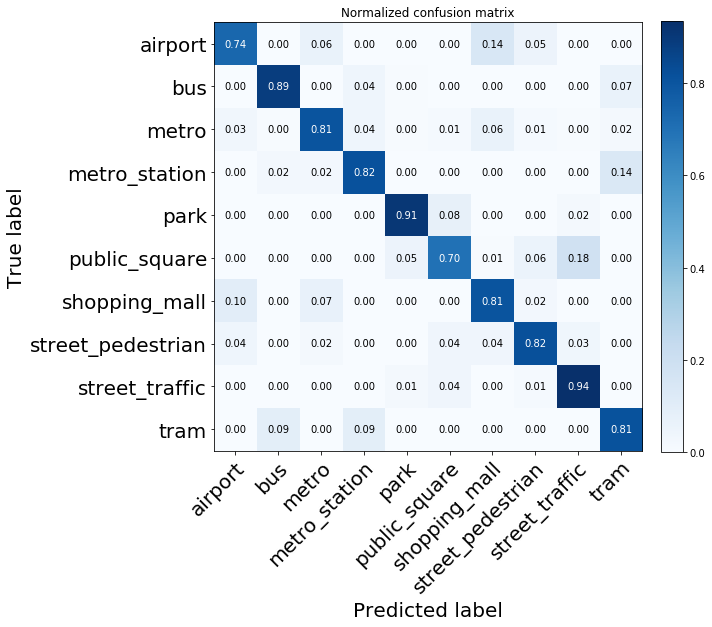

In [7]:
# This came with the notebook - leaving to make sure results match up
#get metrics
Overall_accuracy = np.sum(y_pred_val==y_val_labels)/LM_val.shape[0]
print("overall accuracy: ", Overall_accuracy)

plot_confusion_matrix(y_val_labels, y_pred_val, ClassNames,normalize=True,title=None)

conf_matrix = confusion_matrix(y_val_labels,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
precision_by_class = np.diagonal(conf_mat_norm_precision)
mean_recall = np.mean(recall_by_class)
mean_precision = np.mean(precision_by_class)

print("per-class accuracy (recall): ",recall_by_class)
print("per-class precision: ",precision_by_class)
print("mean per-class recall: ",mean_recall)
print("mean per-class precision: ",mean_precision)